In [18]:
import math as m
import numpy as np
import matplotlib.pyplot as plt
import time 
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [19]:
#0 to 1
x_squared_ans=1/3
def x_squared(x):
    return x**2

#0 to pi
sine_x_ans=2
def sine_x(x):
    return np.sin(x)

# 0 to 1
exp_x_ans=m.e-1
def exp_x(x):
    return np.exp(x)

#1 to 2
one_by_x_ans=m.log(2)
def one_by_x(x):
    return 1/x

In [20]:
def py_trapz(f,a,b,n):
    integration_result=0
    step_size=(b-a)/n
    x=a+0
    x_plus_dx=a+step_size
    current_value=f(x)
    next_value=f(x_plus_dx)

    for i in range(n):
        #integration_result+=(current_value+next_value)*(step_size/2)
        #here step_size is a common factor so we remove it and multiply at the end 
        integration_result+=(current_value+next_value)

        x+=step_size
        current_value=next_value
        x_plus_dx+=step_size
        next_value=f(x_plus_dx)

    integration_result*=(step_size/2)

    return integration_result


In [29]:
%%cython
import cython

@cython.nonecheck(False)
#This decorator disables None checking for variables
@cython.cdivision(True)
#This enables C-style division, which doesn’t check for a division by zero error.
@cython.boundscheck(False)
#Disables bounds checking on array or list indexing.
@cython.wraparound(False)
#Disables negative indexing on arrays.

def cy_trapz(f,float a,float b,int n):
    
    cdef long double integration_result,current_value,next_value,
    cdef float x_plus_dx,xstep_size,
    cdef int i 
    
    integration_result=0
    step_size=(b-a)/n
    x=a+0
    x_plus_dx=a+step_size
    current_value=f(x)
    next_value=f(x_plus_dx)

    for i in range(n):
        #integration_result+=(current_value+next_value)*(step_size/2)
        #here step_size is a common factor so we remove it and multiply at the end 
        integration_result+=(current_value+next_value)

        x+=step_size
        current_value=next_value
        x_plus_dx+=step_size
        next_value=f(x_plus_dx)

    integration_result*=(step_size/2)

    return integration_result
    

Here uncomment any line initializing curr_func to work with and see the results of the desired function
currently x_squared is uncommented and is used

In [42]:
curr_func=x_squared,0,1,x_squared_ans
#curr_func=sine_x,0,m.pi,sine_x_ans
#curr_func=one_by_x,1,2,one_by_x_ans
#curr_func=exp_x,0,1,exp_x_ans

#initializing dictionaries to store values 
time_dictionary={'python':[],'numpy':[],'cython':[]}
error_dict={'python':[],'numpy':[],'cython':[]}

In [37]:
#fucniton to run each integrating function 3 times and get the average time and the percentage error 
def gettime(method, data,n):
    #data is a tuple
    func, a, b, func_answer= data
    sum_time = 0
    sum_error =0
    
    for i in range(3):        
        # Handle numpy case separately
        if method == np.trapz:
            x=np.linspace(a, b, n)  # Generate x values for integration
            y=func(x)               # Generate function values over x
            
            start_time=time.time()
            result=method(y, x)     # Integrate with np.trapz using y and x arrays
            end_time=time.time()
            sum_error+=abs(result - func_answer) / func_answer
        else:
            start_time=time.time()
            result=method(func, a, b, n)
            end_time=time.time()
            sum_error+=abs(result - func_answer) / func_answer
            
        time_elapsed=end_time-start_time
        sum_time+=time_elapsed
    
    # Calculate average time in milliseconds
    time_ms = (sum_time * 1000) / 3
    per_error=abs(result-func_answer)/func_answer
    per_error*=100
    
    return time_ms,per_error

In [38]:
#no of trapezoids 
n=10
max_n=10000000
n_values=list()

This while loop runs for 4 times with values of n as 10, 1000, 100000 and 10000000 . It will a few seconds for it to complete running this block of code 

In [39]:
n = 10
while n <= max_n:
    # Python timer
    timing,error = gettime(py_trapz, curr_func, n)
    (time_dictionary['python']).append(timing)
    (error_dict['python']).append(error)
    
    # Cython timer
    timing,error = gettime(cy_trapz, curr_func, n)
    (time_dictionary['cython']).append(timing)
    (error_dict['cython']).append(error)
    
    # Numpy timer
    timing,error = gettime(np.trapz, curr_func, n)
    (time_dictionary['numpy']).append(timing)
    (error_dict['numpy']).append(error)
    
    n_values.append(n)
    n *= 100

In [40]:
#print(time_dictionary)
#print(error_dict)
#to see the resultant dictionary 

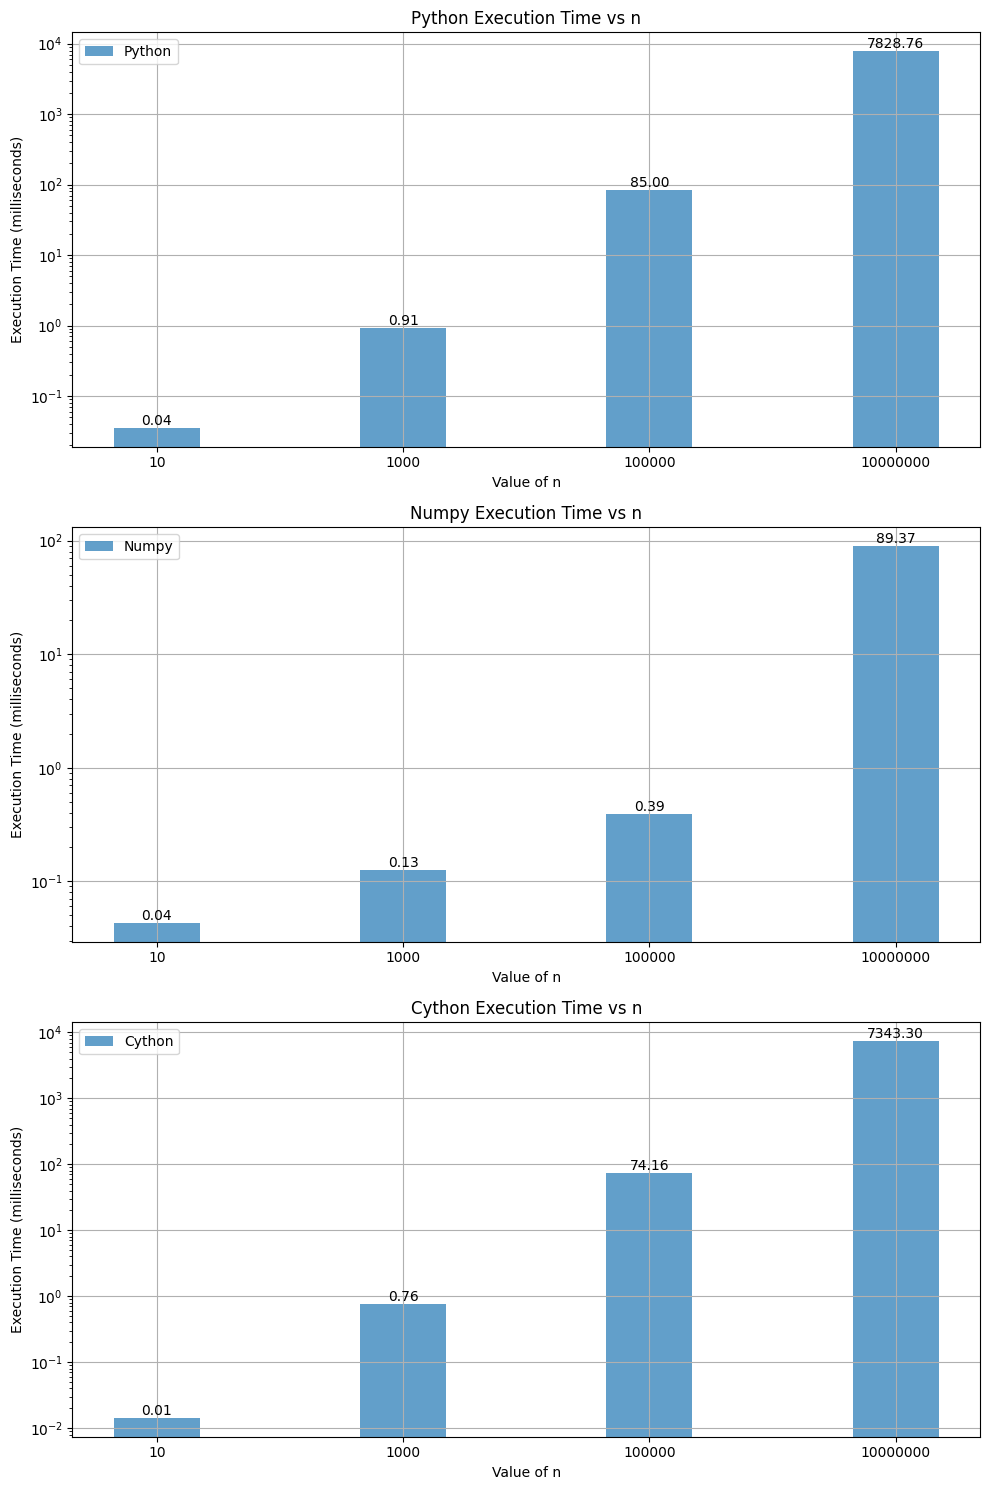

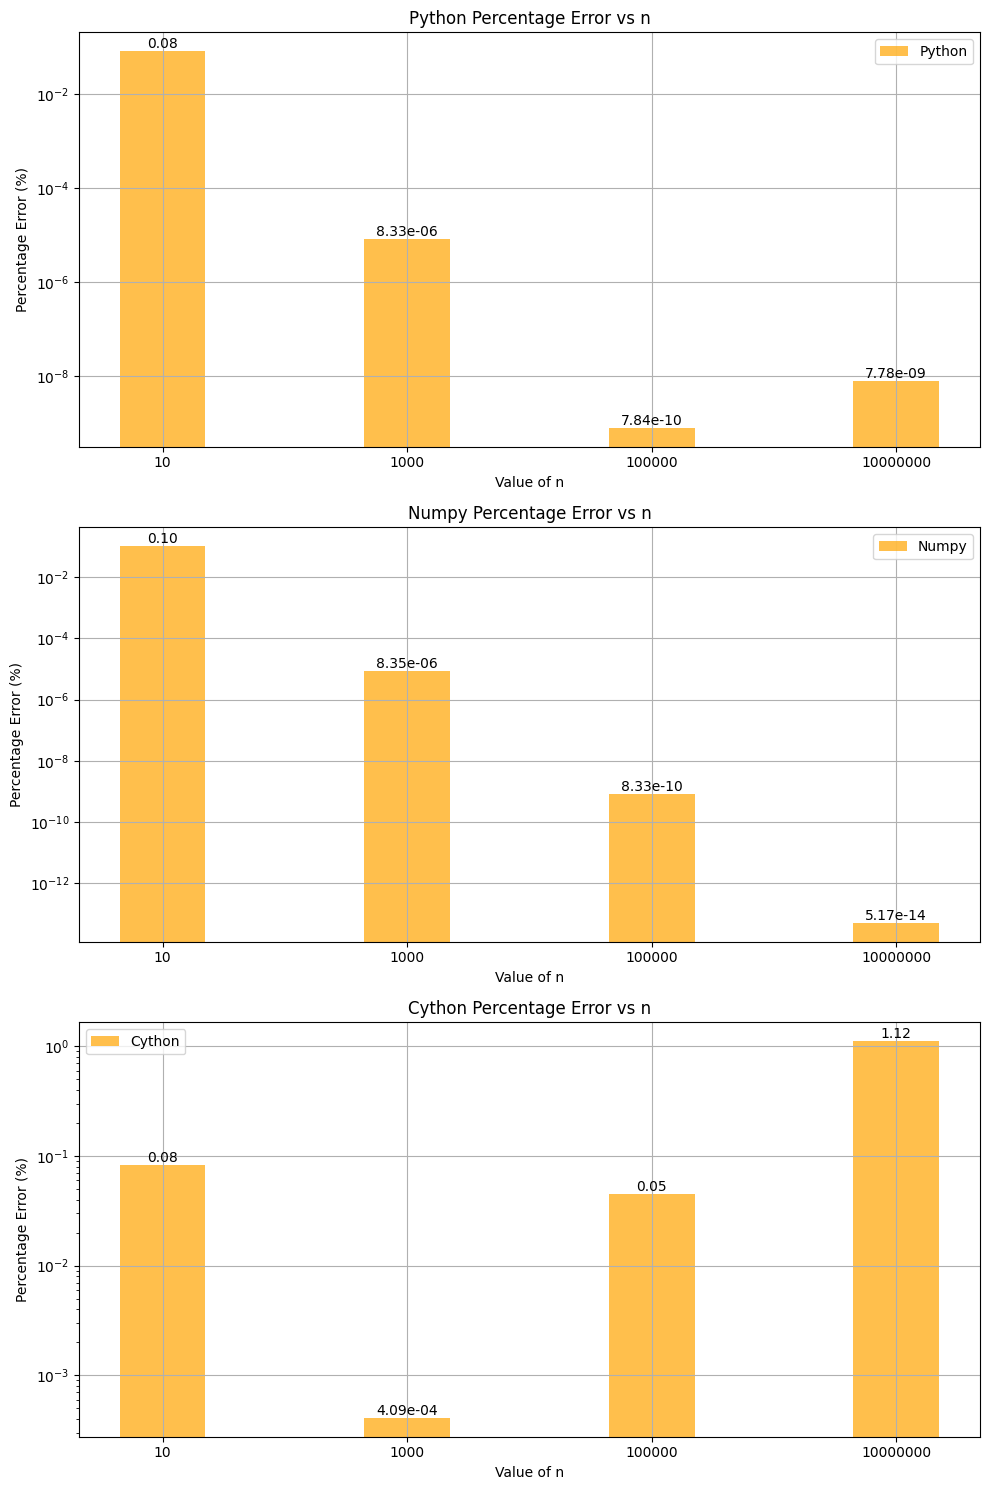

In [41]:
bar_width = 0.35
index = np.arange(len(n_values))

# Plot 1: Execution Time vs n
fig1, axs1 = plt.subplots(3, 1, figsize=(10, 15))
for i, label in enumerate(time_dictionary.keys()):
    bars1 = axs1[i].bar(index, time_dictionary[label], width=bar_width, label=label.capitalize(), alpha=0.7)
    axs1[i].set_title(f"{label.capitalize()} Execution Time vs n")
    axs1[i].set_xlabel("Value of n")
    axs1[i].set_ylabel("Execution Time (milliseconds)")
    axs1[i].set_xticks(index)
    axs1[i].set_xticklabels(n_values)
    axs1[i].set_yscale("log")  # Log scale for y-axis
    axs1[i].grid(True)
    axs1[i].legend()
    
    # Add heights on top of the bars
    for bar in bars1:
        yval = bar.get_height()
        axs1[i].text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Plot 2: Percentage Error vs n
fig2, axs2 = plt.subplots(3, 1, figsize=(10, 15))
for i, label in enumerate(error_dict.keys()):
    bars2 = axs2[i].bar(index, error_dict[label], width=bar_width, label=label.capitalize(), color='orange', alpha=0.7)
    axs2[i].set_title(f"{label.capitalize()} Percentage Error vs n")
    axs2[i].set_xlabel("Value of n")
    axs2[i].set_ylabel("Percentage Error (%)")
    axs2[i].set_xticks(index)
    axs2[i].set_xticklabels(n_values)
    axs2[i].set_yscale("log")  # Log scale for y-axis
    axs2[i].grid(True)
    axs2[i].legend()
    
    # Add heights on top of the bars, formatting small values with scientific notation if needed
    for bar in bars2:
        yval = bar.get_height()
        if yval < 0.01:  # Use scientific notation for very small values
            label_text = f"{yval:.2e}"
        else:
            label_text = f"{yval:.2f}"
        axs2[i].text(bar.get_x() + bar.get_width()/2, yval, label_text, ha='center', va='bottom')

plt.tight_layout()
plt.show()